正在从 '/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv' 加载数据...
已计算 927 个项目的标题长度。

--- 标题长度统计摘要（全部项目） ---
count   927.00
mean     27.15
std       6.56
min       4.00
25%      23.00
50%      27.00
75%      31.00
max      49.00

正在生成 '全部项目标题长度分布' 图表...
[诊断] 原始样本数=927, 可用整数样本数=927
[诊断] 前10个长度值（清洗后）: [4, 4, 6, 7, 7, 7, 9, 9, 9, 9]
[诊断] 唯一长度取值数=41


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


图表已成功保存为: all_projects_length_dist.png (位于 /kaggle/working/ 目录)
正在显示图表: 全部项目标题长度分布


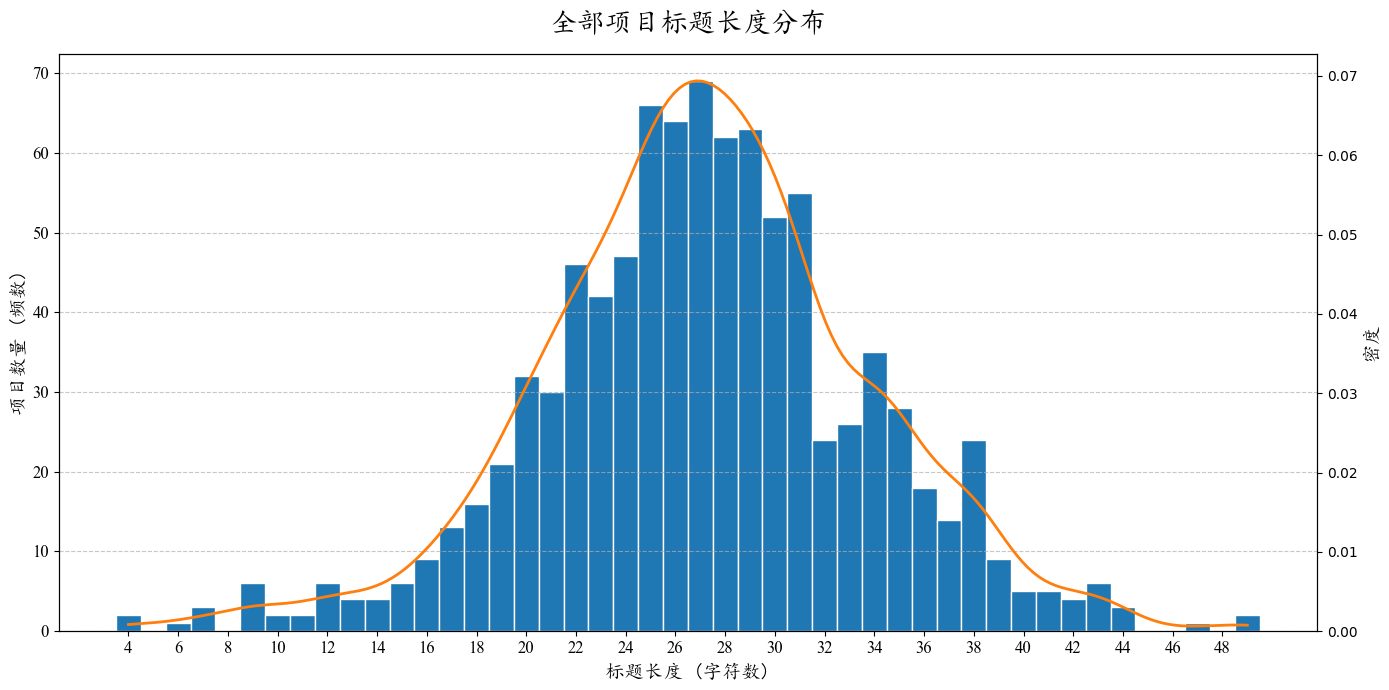

In [1]:
# --- 1. 导入必要的库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os
import sys

# --- 2. 设置文件路径（Kaggle路径） ---
data_file = "/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv"

# 如果你没有上传字体，可保持下面两行为空字符串；若有自定义字体，填入ttf文件的绝对路径即可
font_path_chinese = "/kaggle/input/nsfc2025-management/simkai.ttf"   # 例如："/kaggle/input/myfonts/simkai.ttf"
font_path_english = "/kaggle/input/nsfc2025-management/times.ttf"   # 例如："/kaggle/input/myfonts/times.ttf"

# 字体检查与注册（可选）
if font_path_chinese and os.path.exists(font_path_chinese):
    fm.fontManager.addfont(font_path_chinese)
    ch_font = fm.FontProperties(fname=font_path_chinese)
else:
    if font_path_chinese:
        print(f"警告: 字体文件 '{font_path_chinese}' 未找到。中文可能无法正确显示。")
    ch_font = fm.FontProperties()

if font_path_english and os.path.exists(font_path_english):
    fm.fontManager.addfont(font_path_english)
    en_font = fm.FontProperties(fname=font_path_english)
else:
    if font_path_english:
        print(f"警告: 字体文件 '{font_path_english}' 未找到。非中文字符可能无法使用指定字体。")
    en_font = fm.FontProperties()

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False 

# --- 3. 加载数据并计算标题长度 ---
print(f"正在从 '{data_file}' 加载数据...")
try:
    df = pd.read_csv(data_file, dtype=str, encoding="utf-8")
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。")
    print("请确保数据集已正确挂载到 Kaggle 指定路径。")
    sys.exit()

# 统一去除列名两端空格，兼容“项目名称分词 ”（末尾有空格）的情况
df.columns = [str(c).strip() for c in df.columns]

# 检查所需列
required_cols = {"项目名称", "项目名称分词"}
if not required_cols.issubset(set(df.columns)):
    print(f"错误：数据中缺少必需列。需要列：{required_cols}，当前列：{list(df.columns)}")
    sys.exit()

# 仅保留两列（防御性）
df = df.loc[:, ["项目名称", "项目名称分词"]].copy()

# 确保为字符串
df["项目名称"] = df["项目名称"].astype(str)
df["项目名称分词"] = df["项目名称分词"].astype(str)

# 计算标题长度
df["标题长度"] = df["项目名称"].str.len()
print(f"已计算 {len(df)} 个项目的标题长度。")

# --- 4. 统计摘要（全部项目） ---
print("\n" + "="*50)
print("--- 标题长度统计摘要（全部项目） ---")
summary_df = df["标题长度"].describe()
print(summary_df.to_string(float_format="{:.2f}".format))
print("="*50 + "\n")

# --- 5. 绘制全部项目标题长度分布图（方法A + 自检稳妥版）---
print("正在生成 '全部项目标题长度分布' 图表...")

# 0) 先做健壮的清洗：把“标题长度”安全转数值
lengths_raw = df["标题长度"]
lengths = pd.to_numeric(lengths_raw, errors="coerce")  # 非数字变 NaN
lengths = lengths.dropna().astype(int)

# 1) 快速诊断
print(f"[诊断] 原始样本数={len(lengths_raw)}, 可用整数样本数={len(lengths)}")
print(f"[诊断] 前10个长度值（清洗后）: {lengths.head(10).tolist()}")
print(f"[诊断] 唯一长度取值数={lengths.nunique()}")

if lengths.empty:
    print("错误：清洗后无有效的整数‘标题长度’数据，无法绘图。请检查该列是否为空或为非数字文本。")
else:
    lo, hi = int(lengths.min()), int(lengths.max())
    # 2) 每个整数占一个箱（n-0.5, n+0.5）
    bins = np.arange(lo - 0.5, hi + 1.5, 1)

    fig, ax = plt.subplots(figsize=(14, 7))

    # 3) 用 matplotlib 直方图最稳妥（不依赖 seaborn 版本特性）
    ax.hist(lengths, bins=bins, edgecolor="white")

    # 新建右侧 y 轴画 KDE（KDE 是密度，不跟左轴冲突）
    ax2 = ax.twinx()
    sns.kdeplot(
        lengths,
        ax=ax2,
        bw_adjust=0.8,
        clip=(lo, hi),
        color="C1",        # 或者用 color="tab:orange"
        linewidth=2,
    )
    ax2.set_ylabel('密度', fontproperties=ch_font, fontsize=14)
    ax2.grid(False)  # 右轴不加网格
    
    # 如仍想用 seaborn，请改用下行（两者二选一）。注意：某些版本 shrink 行为不同，可能导致看似“消失”：
    # sns.histplot(lengths, bins=bins, kde=False, color='steelblue', ax=ax, shrink=0)

    # 4) 设定标题与轴标签
    ax.set_title('全部项目标题长度分布', fontproperties=ch_font, fontsize=20, pad=15)
    ax.set_xlabel('标题长度 (字符数)', fontproperties=ch_font, fontsize=14)
    ax.set_ylabel('项目数量 (频数)', fontproperties=ch_font, fontsize=14)

    # 5) X轴整数刻度
    step = max(1, (hi - lo) // 20)  # 最多 ~20 个刻度
    ax.set_xticks(np.arange(lo, hi + 1, step))

    plt.setp(ax.get_xticklabels(), fontproperties=en_font, fontsize=12)
    plt.setp(ax.get_yticklabels(), fontproperties=en_font, fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    fig.tight_layout()

    # 如需 KDE，可单独再叠加（不会影响柱子宽度/是否留缝）
    # sns.kdeplot(lengths, ax=ax)

    output_filename_1 = 'all_projects_length_dist.png'
    try:
        fig.savefig(output_filename_1, dpi=300, bbox_inches='tight')
        print(f"图表已成功保存为: {output_filename_1} (位于 /kaggle/working/ 目录)")
    except Exception as e:
        print(f"保存图表 '{output_filename_1}' 时出错: {e}")

    try:
        print("正在显示图表: 全部项目标题长度分布")
        plt.show()
    except Exception as e:
        print(f"显示图表时出错: {e}")

    plt.close(fig)

